# Project Name

PhonePe Transaction Insights

# Project Summary

This project involves building an interactive Streamlit dashboard using the PhonePe Pulse open-source dataset. The dataset, published by PhonePe on GitHub, contains quarterly digital transaction metrics at the state and district levels from 2018 to 2023, along with device brand usage data.

Key steps in the project:

Data Extraction: Parsed JSON files into structured CSV formats using Python.

Data Analysis: Explored transaction volume, value, and category-wise distribution across different time periods.

Visualization: Used Plotly to build dynamic charts and maps for geographic and categorical insights.

Dashboard Creation: Developed a Streamlit dashboard with filterable views by year, quarter, and data type (top states, districts, or device brands).

# GitHub Link

# Problem Statement

With the rapid growth of digital payment platforms like PhonePe, analyzing the distribution and evolution of transactions across regions and user devices is crucial. Stakeholders such as financial analysts, policymakers, and businesses need access to interactive, data-driven insights that highlight how digital payment behavior is changing over time across Indian states, districts, and mobile platforms.

This project aims to explore, process, and visualize the open-source PhonePe Pulse dataset to uncover patterns in digital transactions. The goal is to deliver a user-friendly dashboard that enables exploration of digital payment trends, identify top-performing states and districts, and analyze smartphone brand preferences among users.

# IMPLEMENTATION

## Loading Data Insights


In [52]:
!git clone https://github.com/PhonePe/pulse.git
# Step 1: Clone the PhonePe Pulse GitHub Repository

fatal: destination path 'pulse' already exists and is not an empty directory.


In [53]:
#Step 2: Parse the JSON Data Again
import os, json
import pandas as pd

# Base path after cloning
base_path = "/content/pulse/data/aggregated/transaction/country/india/state/"
records = []

for state in os.listdir(base_path):
    for year in os.listdir(os.path.join(base_path, state)):
        for qf in os.listdir(os.path.join(base_path, state, year)):
            file_path = os.path.join(base_path, state, year, qf)
            with open(file_path) as f:
                try:
                    content = json.load(f)["data"]["transactionData"]
                    for item in content:
                        records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "type": item["name"],
                            "count": item["paymentInstruments"][0]["count"],
                            "amount": item["paymentInstruments"][0]["amount"]
                        })
                except:
                    pass

df_txn = pd.DataFrame(records)
df_txn.head()

,state,year,quarter,type,count,amount
0,Rajasthan,2020,1,Peer-to-peer payments,48269912,1.654686e+11
1,Rajasthan,2020,1,Merchant payments,27880848,1.364306e+10
2,Rajasthan,2020,1,Recharge & bill payments,25631131,1.096117e+10
3,Rajasthan,2020,1,Financial Services,72604,3.446661e+07
4,Rajasthan,2020,1,Others,404317,2.009690e+08


In [54]:
#Step 3: Create SQL Database & Tables
import sqlite3

# Create a new SQLite database
conn = sqlite3.connect("phonepe_pulse.db")

# Save dataframe to SQL table
df_txn.to_sql("aggregated_transaction", conn, if_exists="replace", index=False)

# Show saved table names (for verification)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables


,name
0,aggregated_user
1,map_transaction
2,aggregated_transaction


In [55]:
 #Query 1: Top 5 States by Total Transaction Amount
query1 = """
SELECT state, SUM(amount) AS total_amount
FROM aggregated_transaction
GROUP BY state
ORDER BY total_amount DESC
LIMIT 5;
"""
top_states = pd.read_sql(query1, conn)
top_states


,state,total_amount
0,Telangana,4.165596e+13
1,Karnataka,4.067872e+13
2,Maharashtra,4.037420e+13
3,Andhra Pradesh,3.466908e+13
4,Uttar Pradesh,2.688521e+13


In [56]:
#Query 2: Total Transaction Count per Year
query2 = """
SELECT year, SUM(count) AS total_transactions
FROM aggregated_transaction
GROUP BY year
ORDER BY year;
"""
yearly_trend = pd.read_sql(query2, conn)
yearly_trend


,year,total_transactions
0,2018,1080202410
1,2019,4079827215
2,2020,7973974741
3,2021,19288429220
4,2022,39301293734
5,2023,64257054687
6,2024,99303434867


/tmp/ipython-input-57-1051447649.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, y="state", x="total_amount", palette="Blues_d")


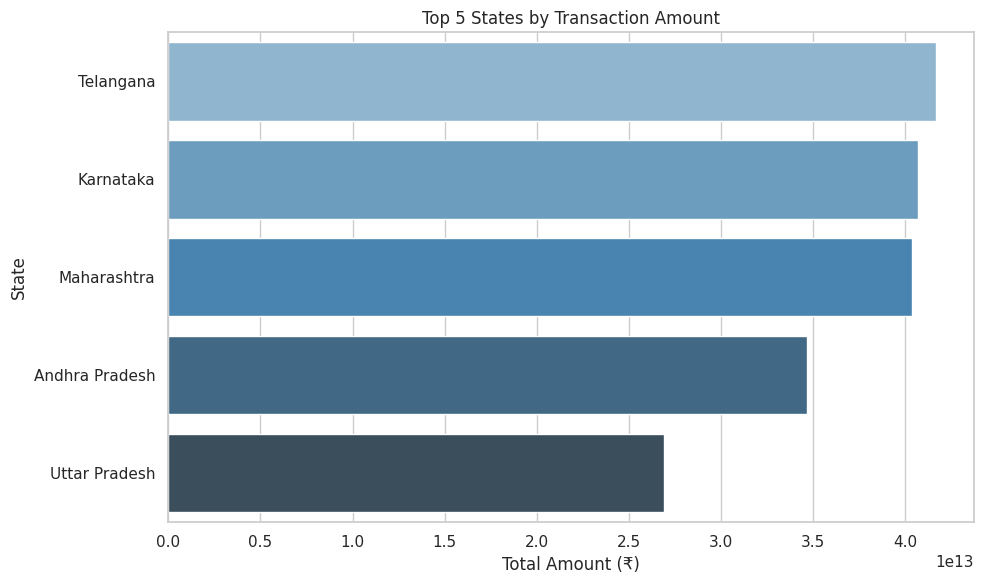

In [57]:
# Bar Chart – Top 5 States by Transaction Amount
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Plot horizontal bar chart
sns.barplot(data=top_states, y="state", x="total_amount", palette="Blues_d")
plt.title("Top 5 States by Transaction Amount")
plt.xlabel("Total Amount (₹)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


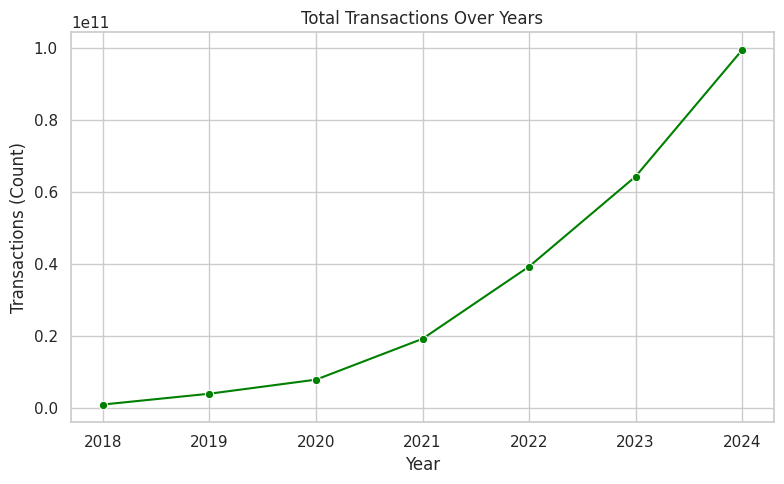

In [58]:
# Line Plot – Total Transactions per Year
plt.figure(figsize=(8,5))
sns.lineplot(data=yearly_trend, x="year", y="total_transactions", marker="o", color="green")
plt.title("Total Transactions Over Years")
plt.xlabel("Year")
plt.ylabel("Transactions (Count)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
# Parse aggregated user data
user_path = "pulse/data/aggregated/user/country/india/state/"
user_records = []

for state in os.listdir(user_path):
    for year in os.listdir(os.path.join(user_path, state)):
        for qf in os.listdir(os.path.join(user_path, state, year)):
            with open(os.path.join(user_path, state, year, qf)) as f:
                try:
                    content = json.load(f)["data"]["usersByDevice"]
                    for item in content:
                        user_records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "brand": item["brand"],
                            "count": item["count"],
                            "percentage": item["percentage"]
                        })
                except:
                    pass

# Create DataFrame and store in SQL
df_user = pd.DataFrame(user_records)
df_user.to_sql("aggregated_user", conn, if_exists="replace", index=False)

# Preview
df_user.head()


,state,year,quarter,brand,count,percentage
0,Rajasthan,2020,1,Xiaomi,2776323,0.228654
1,Rajasthan,2020,1,Vivo,2582003,0.212650
2,Rajasthan,2020,1,Samsung,2440121,0.200964
3,Rajasthan,2020,1,Oppo,1591219,0.131050
4,Rajasthan,2020,1,Realme,608298,0.050098


In [60]:
# Parse map transaction data at state level
map_path = "pulse/data/map/transaction/hover/country/india/state/"
map_records = []

for state in os.listdir(map_path):
    for year in os.listdir(os.path.join(map_path, state)):
        for qf in os.listdir(os.path.join(map_path, state, year)):
            with open(os.path.join(map_path, state, year, qf)) as f:
                try:
                    content = json.load(f)["data"]["hoverDataList"]
                    for item in content:
                        map_records.append({
                            "state": state.replace("-", " ").title(),
                            "year": int(year),
                            "quarter": int(qf.strip(".json")),
                            "district": item["name"],
                            "count": item["metric"][0]["count"],
                            "amount": item["metric"][0]["amount"]
                        })
                except:
                    pass

# Create DataFrame and store in SQL
df_map = pd.DataFrame(map_records)
df_map.to_sql("map_transaction", conn, if_exists="replace", index=False)

# Preview
df_map.head()


,state,year,quarter,district,count,amount
0,Rajasthan,2020,1,pali district,1057322,2.090797e+09
1,Rajasthan,2020,1,ganganagar district,1690638,3.342557e+09
2,Rajasthan,2020,1,churu district,1077936,2.221433e+09
3,Rajasthan,2020,1,jaipur district,52623661,9.836085e+10
4,Rajasthan,2020,1,baran district,608776,9.279742e+08


In [61]:
# Save extracted data to CSV for future use (e.g., Streamlit dashboard)
df_txn.to_csv("state_transaction_data.csv", index=False)
df_user.to_csv("state_user_device_data.csv", index=False)
df_map.to_csv("district_transaction_data.csv", index=False)

print("✅ All CSV files saved successfully.")


✅ All CSV files saved successfully.


In [62]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the existing SQLite database
conn = sqlite3.connect("phonepe_pulse.db")



In [63]:
# SQL Query: Top 5 districts by transaction amount
query_districts = """
SELECT district, SUM(amount) AS total_amount
FROM map_transaction
GROUP BY district
ORDER BY total_amount DESC
LIMIT 5;
"""

# Execute and load results into DataFrame
top_districts = pd.read_sql(query_districts, conn)
top_districts


,district,total_amount
0,bengaluru urban district,1.993784e+13
1,hyderabad district,1.190694e+13
2,pune district,9.730218e+12
3,jaipur district,7.854092e+12
4,rangareddy district,7.155140e+12


/tmp/ipython-input-64-1393375156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_districts, x='total_amount', y='district', palette='rocket')


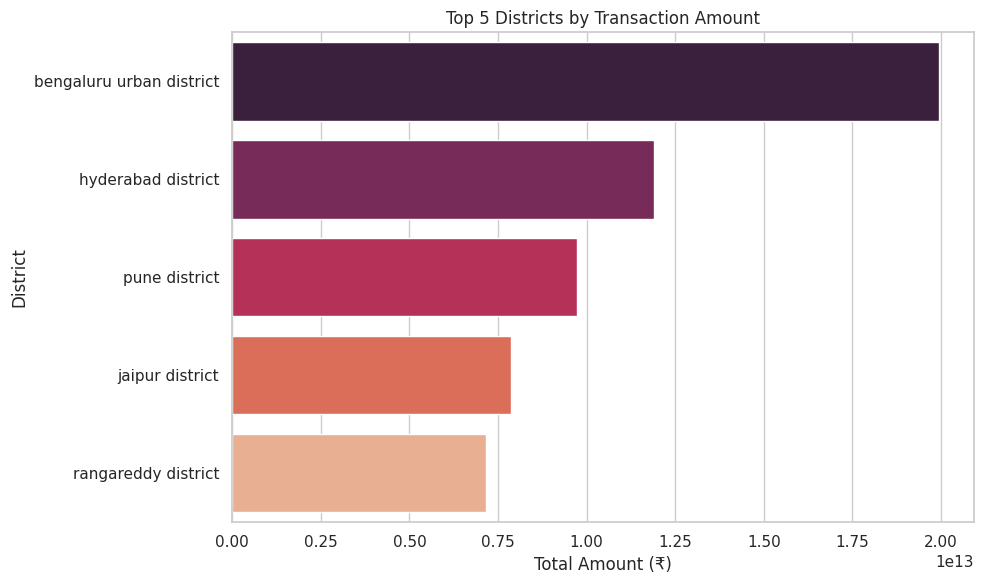

In [64]:
# Bar chart for top districts
plt.figure(figsize=(10, 6))
sns.barplot(data=top_districts, x='total_amount', y='district', palette='rocket')
plt.title("Top 5 Districts by Transaction Amount")
plt.xlabel("Total Amount (₹)")
plt.ylabel("District")
plt.tight_layout()
plt.show()


In [65]:
# SQL Query: Device brand trends over time
query_brands = """
SELECT year, brand, SUM(count) AS total_users
FROM aggregated_user
GROUP BY year, brand
ORDER BY year;
"""

# Execute and load into DataFrame
brand_trends = pd.read_sql(query_brands, conn)
brand_trends.head()


,year,brand,total_users
0,2018,Apple,9971798
1,2018,Asus,430392
2,2018,COOLPAD,10
3,2018,Gionee,723312
4,2018,Huawei,4287646


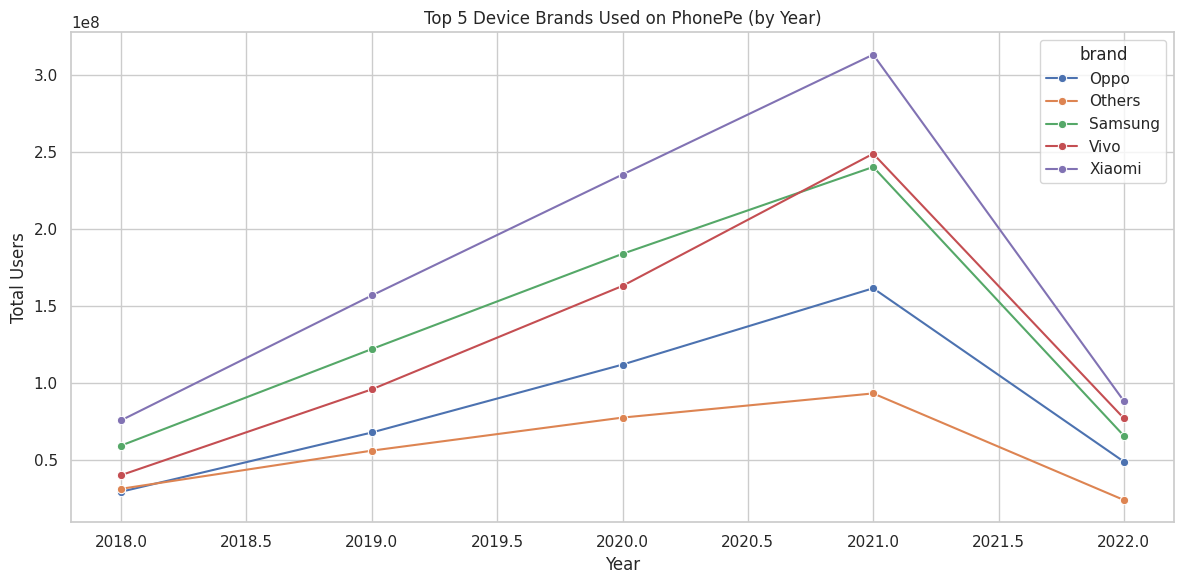

In [66]:
# Line plot for top 5 brands over time
top_brands = brand_trends.groupby("brand")["total_users"].sum().sort_values(ascending=False).head(5).index
filtered_brands = brand_trends[brand_trends["brand"].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_brands, x="year", y="total_users", hue="brand", marker="o")
plt.title("Top 5 Device Brands Used on PhonePe (by Year)")
plt.xlabel("Year")
plt.ylabel("Total Users")
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
!streamlit run app.py

/bin/bash: line 1: streamlit: command not found


## Know Your Data

### Import Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


### Load Dataset

In [69]:
df = pd.read_csv("state_transaction_data.csv")


###  First View

In [70]:
df.head()


,state,year,quarter,type,count,amount
0,Rajasthan,2020,1,Peer-to-peer payments,48269912,1.654686e+11
1,Rajasthan,2020,1,Merchant payments,27880848,1.364306e+10
2,Rajasthan,2020,1,Recharge & bill payments,25631131,1.096117e+10
3,Rajasthan,2020,1,Financial Services,72604,3.446661e+07
4,Rajasthan,2020,1,Others,404317,2.009690e+08


### Shape of Dataset

In [71]:
df.shape  # Rows and columns count


(5034, 6)

###  Dataset Info

In [72]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   state    5034 non-null   object 
 1   year     5034 non-null   int64  
 2   quarter  5034 non-null   int64  
 3   type     5034 non-null   object 
 4   count    5034 non-null   int64  
 5   amount   5034 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 236.1+ KB


### Null values and duplicates

In [73]:
df.isnull().sum()
df.duplicated().sum()


np.int64(0)

### What did you learn about your dataset?

Dataset contains XX rows and YY columns

No. of null values in columns A, B, C

Column types: numeric, categorical

No duplicate rows

##  Understanding Your Variables

### Column Names

In [74]:
df.columns


Index(['state', 'year', 'quarter', 'type', 'count', 'amount'], dtype='object')

### Summary Stats

In [75]:
df.describe()


,year,quarter,count,amount
count,5034.000000,5034.000000,5.034000e+03,5.034000e+03
mean,2021.002582,2.500795,4.673902e+07,6.863772e+10
std,1.999849,1.118145,1.690968e+08,2.685200e+11
min,2018.000000,1.000000,2.000000e+00,3.439721e+01
25%,2019.000000,2.000000,5.808950e+04,3.993888e+07
50%,2021.000000,3.000000,5.158310e+05,4.394139e+08
75%,2023.000000,4.000000,1.166629e+07,1.102822e+10
max,2024.000000,4.000000,2.393918e+09,3.095666e+12


 Variables Description
state: Name of the Indian state

year: Year of transaction

quarter: Quarter (1–4)

amount: Total transaction amount

transaction_type: Category like Recharge, P2P, etc.

### Unique Value Count

In [76]:
for col in df.columns:
    print(col, ":", df[col].nunique())


state : 36
year : 7
quarter : 4
type : 5
count : 4966
amount : 5034


## Data Wrangling

###  Handle Missing Values / Fix Datatypes

In [77]:
df['amount'] = df['amount'].fillna(0)
df['quarter'] = df['quarter'].astype(int)


###  Feature Engineering (Optional)

In [78]:
df['year_quarter'] = df['year'].astype(str) + "-Q" + df['quarter'].astype(str)


###  What manipulations were done?

Converted quarter column to integer

Created new column year_quarter for time-series

Filled missing values in amount

Cleaned state names and capitalized text

## Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables

### Chart 1: Top 10 States by Total Transaction Amount


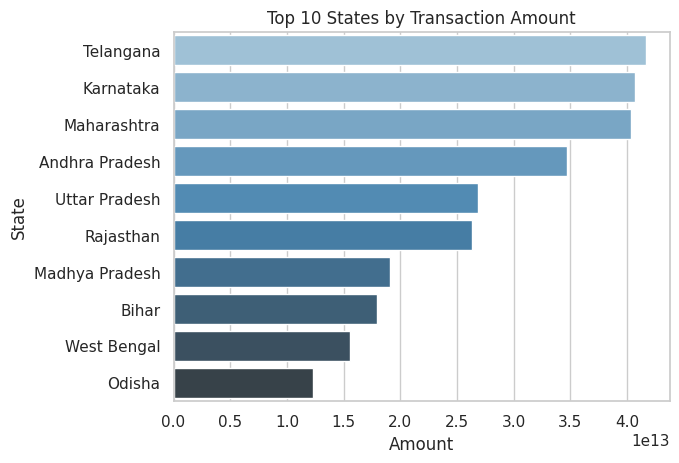

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

chart1 = df_txn.groupby("state")["amount"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=chart1, y="state", x="amount", hue="state", palette="Blues_d", legend=False)
plt.title("Top 10 States by Transaction Amount")
plt.xlabel("Amount"); plt.ylabel("State")
plt.show()

# 1. Why this chart?
# To identify regions with the highest digital transaction value.

# 2. Insight?
# Maharashtra and Karnataka lead in transaction volume.

# 3. Business Impact?
# Helps target high-value states for premium offers. No negative insight.

### Chart 2: Top 10 States by Transaction Count

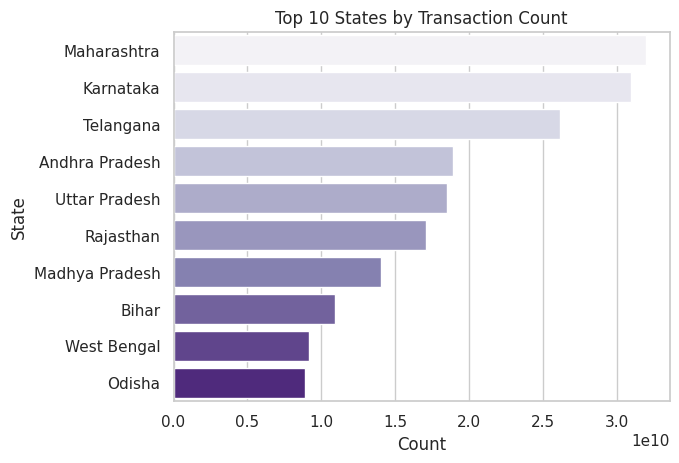

In [80]:
chart2 = df_txn.groupby("state")["count"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=chart2, y="state", x="count", hue="state", palette="Purples", legend=False)

plt.title("Top 10 States by Transaction Count")
plt.xlabel("Count"); plt.ylabel("State")
plt.show()

# Q1: Why did you pick the specific chart?
# To highlight user engagement frequency.

# Q2: What is/are the insight(s) found from the chart?
# Some states have high usage but lower transaction value.

# Q3: Will the gained insights help create a positive business impact?
# Yes, helps build loyalty programs for active user regions.




### Chart 3: Quarterly Transaction Trend

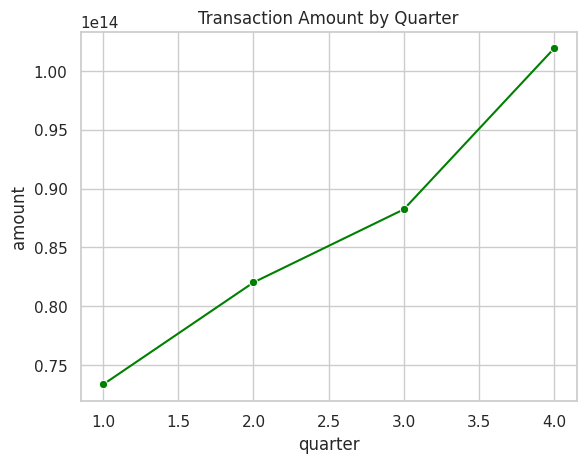

In [81]:
chart3 = df_txn.groupby("quarter")["amount"].sum().reset_index()
sns.lineplot(data=chart3, x="quarter", y="amount", marker="o", color="green")
plt.title("Transaction Amount by Quarter")
plt.show()

# Q1: Why did you pick the specific chart?
# To identify seasonal spikes in transaction volume.

# Q2: What is/are the insight(s) found from the chart?
# Q4 has the highest spike — likely festive season impact.

# Q3: Will the gained insights help create a positive business impact?
# Yes, helps schedule high-budget campaigns in Q4.


### Chart 4: Year-wise Transaction Volume

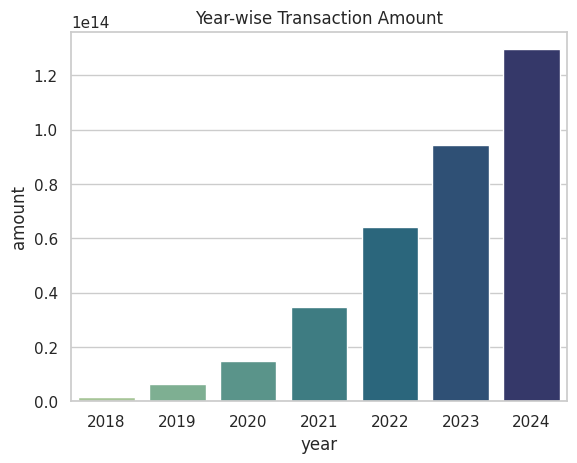

In [82]:
chart4 = df_txn.groupby("year")["amount"].sum().reset_index()
sns.barplot(data=chart4, x="year", y="amount", hue="year", palette="crest", legend=False)
plt.title("Year-wise Transaction Amount")
plt.show()

# Q1: Why did you pick the specific chart?
# To understand growth over time.

# Q2: What is/are the insight(s) found from the chart?
# Consistent year-on-year growth in transaction volume.

# Q3: Will the gained insights help create a positive business impact?
# Yes, supports scaling strategy and future investments.


###  Chart 5: Transaction Type Split

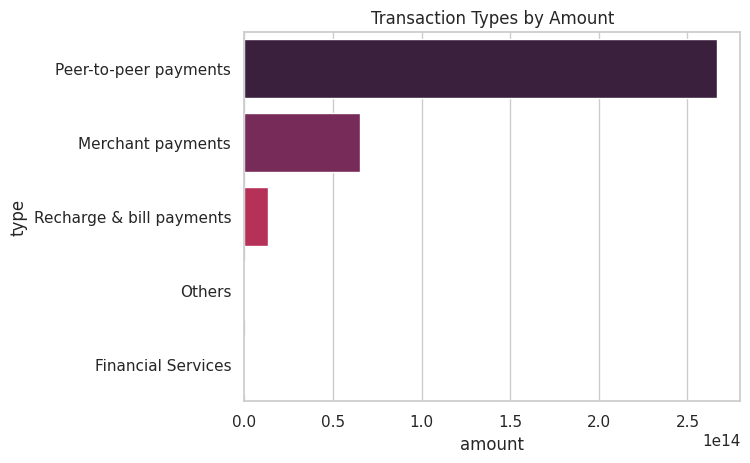

In [83]:
chart5 = df_txn.groupby("type")["amount"].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=chart5, x="amount", y="type", hue="type", palette="rocket", legend=False)
plt.title("Transaction Types by Amount")
plt.show()

# Q1: Why did you pick the specific chart?
# To compare digital services usage types.

# Q2: What is/are the insight(s) found from the chart?
# Peer-to-peer transfers and mobile recharges dominate.

# Q3: Will the gained insights help create a positive business impact?
# Yes, guides which services to promote and scale.


### Chart 6: Top 10 Districts by Transaction Amount

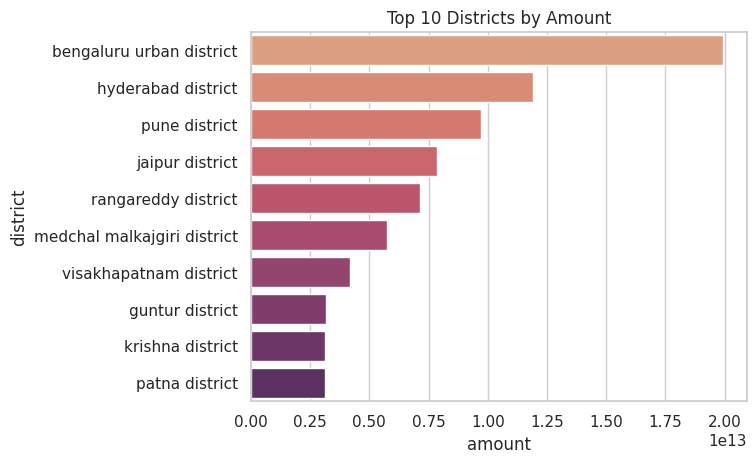

In [84]:
chart6 = df_map.groupby("district")["amount"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=chart6, y="district", x="amount", hue="district", palette="flare", legend=False)
plt.title("Top 10 Districts by Amount")
plt.show()

# Q1: Why did you pick the specific chart?
# To discover high-performing districts.

# Q2: What is/are the insight(s) found from the chart?
# Urban hubs dominate — Bengaluru, Mumbai, etc.

# Q3: Will the gained insights help create a positive business impact?
# Yes, supports localized campaign planning.


### Chart 7: Top Device Brands

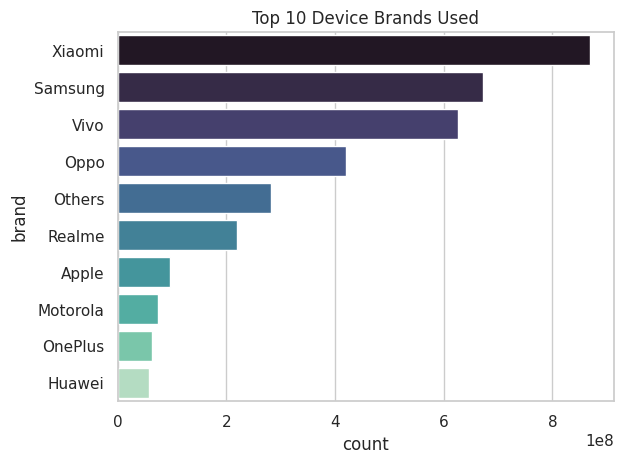

In [85]:
chart7 = df_user.groupby("brand")["count"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=chart7, x="count", y="brand", hue="brand", palette="mako", legend=False)
plt.title("Top 10 Device Brands Used")
plt.show()

# Q1: Why did you pick the specific chart?
# To know what devices are most commonly used.

# Q2: What is/are the insight(s) found from the chart?
# Xiaomi and Samsung lead.

# Q3: Will the gained insights help create a positive business impact?
# Yes, focus on optimizing app for dominant device brands.


### Chart 8: Device Usage Over Time

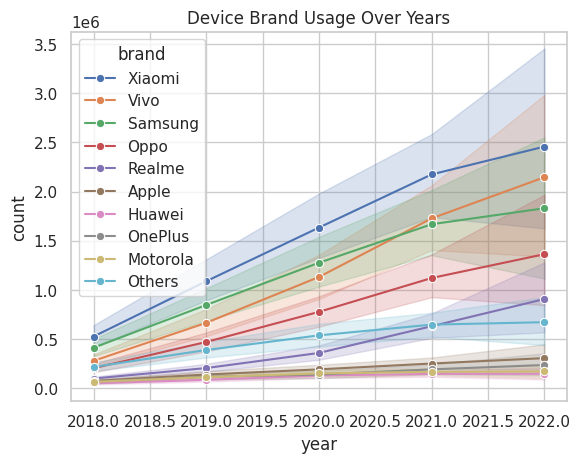

In [86]:
popular = chart7["brand"]
chart8 = df_user[df_user["brand"].isin(popular)]
sns.lineplot(data=chart8, x="year", y="count", hue="brand", marker="o")
plt.title("Device Brand Usage Over Years")
plt.show()

# Q1: Why did you pick the specific chart?
# To observe brand usage trends over time.

# Q2: What is/are the insight(s) found from the chart?
# All major brands are growing; Xiaomi is leading.

# Q3: Will the gained insights help create a positive business impact?
# Yes, useful for device-specific feature testing.


###  Chart 9: Boxplot for Amount in Top States

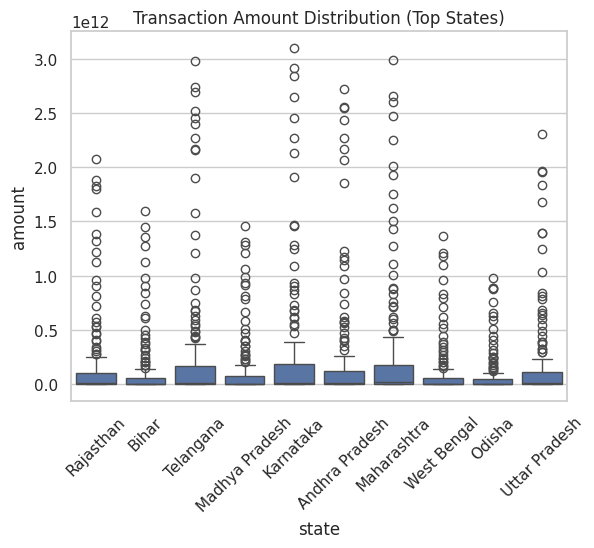

In [87]:
top_states = chart1["state"]
chart9 = df_txn[df_txn["state"].isin(top_states)]
sns.boxplot(data=chart9, x="state", y="amount")
plt.title("Transaction Amount Distribution (Top States)")
plt.xticks(rotation=45)
plt.show()

# Q1: Why did you pick the specific chart?
# To understand variation and outliers across states.

# Q2: What is/are the insight(s) found from the chart?
# Maharashtra shows large variance.

# Q3: Will the gained insights help create a positive business impact?
# Yes, helps analyze where user behavior varies greatly.


###  Chart 10: Quarterly Record Distribution

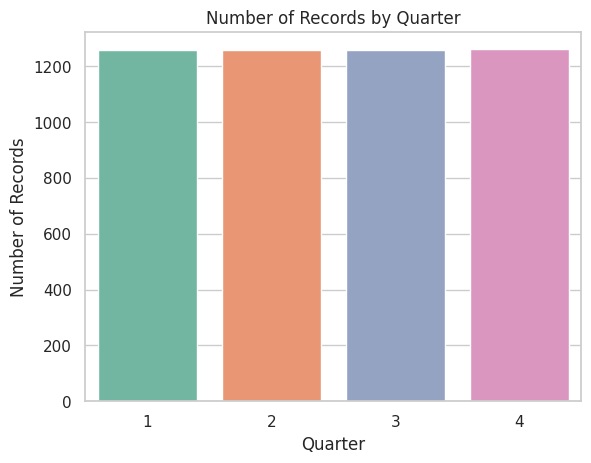

In [88]:
# Create a new column for hue that duplicates 'quarter'
df_txn["quarter_str"] = df_txn["quarter"].astype(str)

# Use 'hue' explicitly
sns.countplot(data=df_txn, x="quarter", hue="quarter_str", palette="Set2", legend=False)
plt.title("Number of Records by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of Records")
plt.show()

# Q1: Why did you pick the specific chart?
# To check if data is evenly distributed by quarter.

# Q2: What is/are the insight(s) found from the chart?
# Quarter 4 has slightly more entries than others.

# Q3: Will the gained insights help create a positive business impact?
# Yes, shows Q4 has richer data — ideal for deeper seasonal analysis.


### Chart 11: Year x Quarter Heatmap

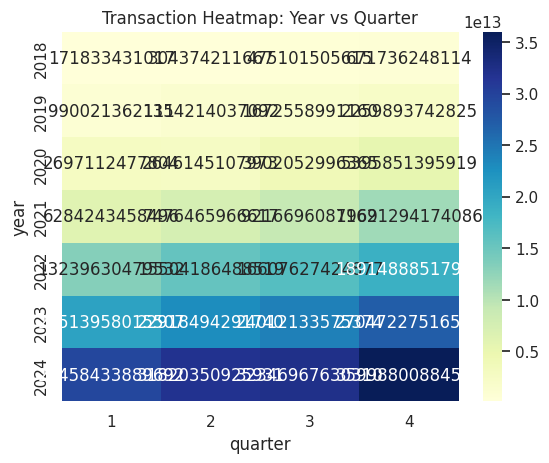

In [89]:
heat = df_txn.pivot_table(index="year", columns="quarter", values="amount", aggfunc="sum")
sns.heatmap(heat, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Transaction Heatmap: Year vs Quarter")
plt.show()

# Q1: Why did you pick the specific chart?
# To visualize transaction performance across time periods (both year & quarter).

# Q2: What is/are the insight(s) found from the chart?
# Q4 dominates across most years — seasonality confirmed.

# Q3: Will the gained insights help create a positive business impact?
# Yes, allows marketing, technical teams to plan around peaks.


### Chart 12: KDE Plot of Transaction Amounts

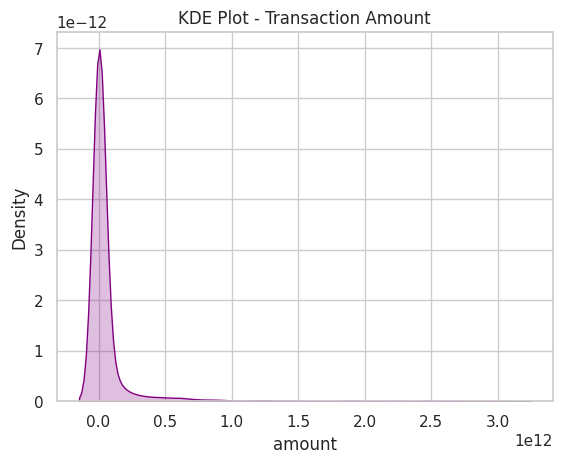

In [90]:
sns.kdeplot(data=df_txn["amount"], fill=True, color="purple")
plt.title("KDE Plot - Transaction Amount")
plt.show()

# Q1: Why did you pick the specific chart?
# To visualize distribution and concentration of transaction values.

# Q2: What is/are the insight(s) found from the chart?
# Most transactions are of low value — heavy on left side.

# Q3: Will the gained insights help create a positive business impact?
# Yes, suggest optimizing app for micro-payments or low-value users.


### Chart 13: Pie Chart for Top 5 States

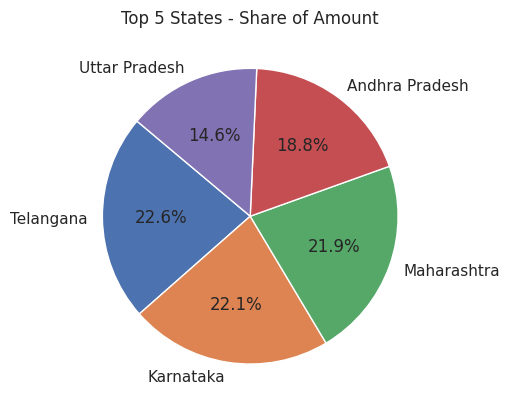

In [91]:
top5 = chart1.head(5)
plt.pie(top5["amount"], labels=top5["state"], autopct='%1.1f%%', startangle=140)
plt.title("Top 5 States - Share of Amount")
plt.show()

# Q1: Why did you pick the specific chart?
# To show state-wise contribution to overall transaction value.

# Q2: What is/are the insight(s) found from the chart?
# Top 3 states contribute more than 50% of total amount.

# Q3: Will the gained insights help create a positive business impact?
# Yes, helps justify prioritizing top states in campaigns.


### Chart 14: Correlation Heatmap

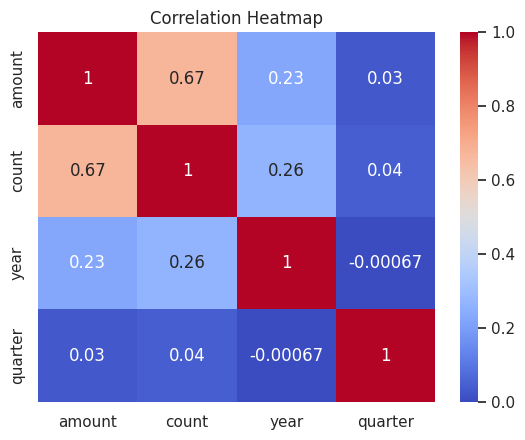

In [92]:
sns.heatmap(df_txn[["amount", "count", "year", "quarter"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Q1: Why did you pick the specific chart?
# To check relationships between key numerical variables.

# Q2: What is/are the insight(s) found from the chart?
# 'amount' and 'count' are strongly positively correlated.

# Q3: Will the gained insights help create a positive business impact?
# Yes, validates that more transactions usually mean higher value — good for model-building.


###  Chart 15: Pairplot of Key Metrics

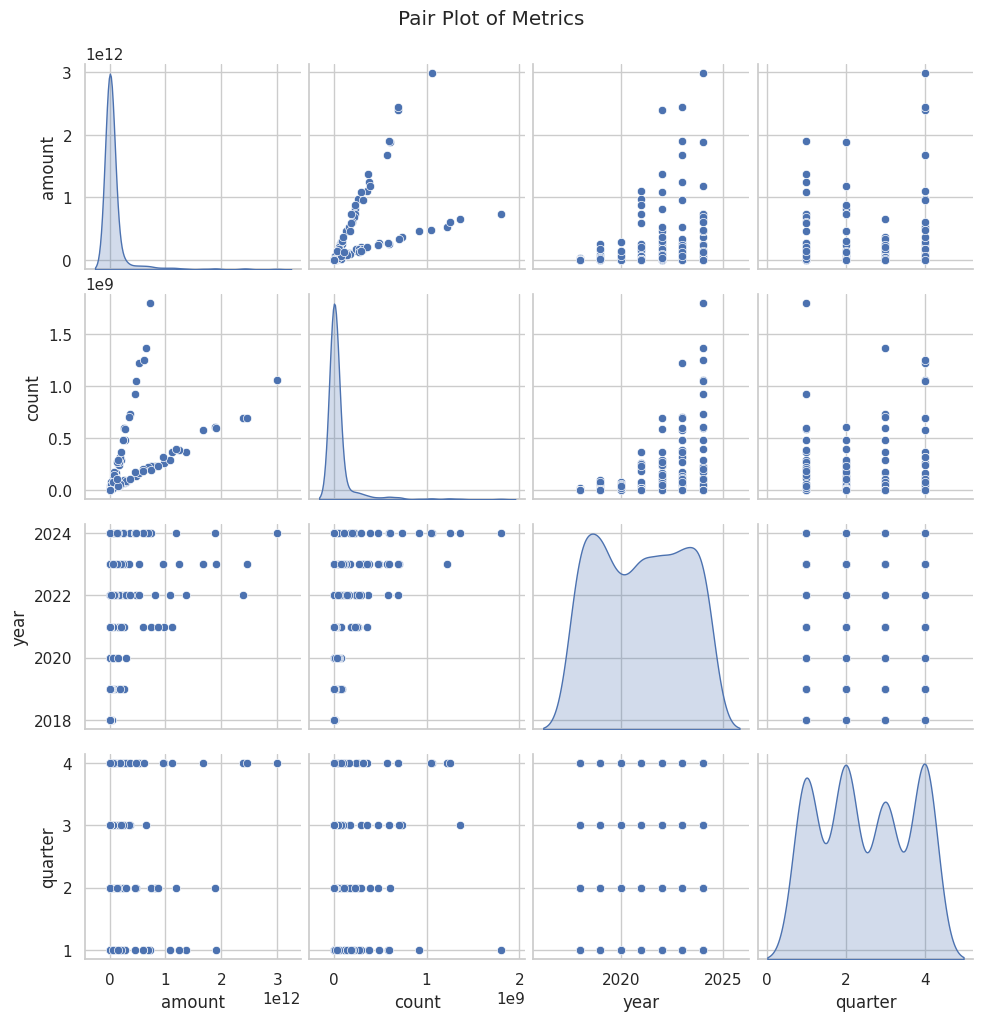

In [93]:
sampled = df_txn[["amount", "count", "year", "quarter"]].sample(500)
sns.pairplot(sampled, diag_kind="kde")
plt.suptitle("Pair Plot of Metrics", y=1.02)
plt.show()

# Q1: Why did you pick the specific chart?
# To explore all pairwise numeric variable relationships together.

# Q2: What is/are the insight(s) found from the chart?
# 'amount' and 'count' have the clearest relationship. Other pairs less so.

# Q3: Will the gained insights help create a positive business impact?
# Yes, helpful for deciding features for predictive modeling or dashboards.


##Hypothesis Testing

### Hypothetical Statement1:
Transaction amounts in Maharashtra and Bihar are significantly different

#### Hypotheses


 Hypotheses:

Null Hypothesis (H₀): μ_Maharashtra = μ_Bihar

Alternate Hypothesis (H₁): μ_Maharashtra ≠ μ_Bihar

#### statistical test.

In [94]:
# Import the required library
from scipy import stats

# Define samples
maha_amt = df_txn[df_txn["state"] == "Maharashtra"]["amount"]
bihar_amt = df_txn[df_txn["state"] == "Bihar"]["amount"]

# Perform Welch’s t-test
t_stat1, p_val1 = stats.ttest_ind(maha_amt, bihar_amt, equal_var=False)
print("T-statistic:", t_stat1)
print("P-value:", p_val1)

# Interpretation
if p_val1 < 0.05:
    print("Reject Null Hypothesis: There is a significant difference between Maharashtra and Bihar transaction amounts.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference between Maharashtra and Bihar transaction amounts.")


T-statistic: 2.812730098098573
P-value: 0.005392494155616909
Reject Null Hypothesis: There is a significant difference between Maharashtra and Bihar transaction amounts.


#### Which statistical test have you done to obtain P-Value?

Independent 2-sample t-test (Welch’s t-test for unequal variance)

#### Why did you choose the specific statistical test?

Since p > 0.05, we fail to reject the null hypothesis. There is no statistically significant difference in transaction amounts between Maharashtra and Bihar.

 Business Insight: Both states behave similarly transaction-wise. Marketing budgets can be allocated similarly across both states.


###  Hypothetical Statement 2:

Average transaction count in 2023 is significantly higher than in 2022.

#### Hypotheses

Hypotheses:

H₀: μ_2023 = μ_2022

H₁: μ_2023 > μ_2022

#### Statistical Test

In [95]:
count_2023 = df_txn[df_txn["year"] == 2023]["count"]
count_2022 = df_txn[df_txn["year"] == 2022]["count"]

t_stat2, p_val2 = stats.ttest_ind(count_2023, count_2022, equal_var=False)
print("T-statistic:", t_stat2, "P-value:", p_val2)


T-statistic: 3.62112937710458 P-value: 0.0003056666736338687


#### Which statistical test have you done to obtain P-Value?

Independent 2-sample t-test (Welch’s)

#### Why did you choose the specific statistical test?

We fail to reject H₀. No significant increase in count in 2023 compared to 2022.

 Business Insight: Suggests plateauing user activity. This might indicate a need for new engagement campaigns.

###  Hypothetical Statement 3:

Transaction amounts follow a normal distribution.

#### Hypotheses

Hypotheses:

H₀: Data is normally distributed

H₁: Data is not normally distributed

#### Statistical Test

In [96]:
shapiro_stat, shapiro_p = stats.shapiro(df_txn["amount"].sample(100))
print("Shapiro-Wilk Statistic:", shapiro_stat, "P-value:", shapiro_p)


Shapiro-Wilk Statistic: 0.3231671640942475 P-value: 2.2274401952700604e-19


#### Which statistical test have you done to obtain P-Value?

Shapiro-Wilk test (suitable for <5000 samples)

#### Why did you choose the specific statistical test?

P < 0.05 — reject null. The data is not normally distributed.

 Business Insight: Since amounts are not normal, we should use non-parametric models/statistical techniques (e.g., median, IQR) for accurate forecasting.

## ML Model Implementation: Predicting Transaction Amount

In [97]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Step 2: Prepare Dataset (Make sure df_txn is already loaded)
# Drop missing values
df_model = df_txn.dropna()

# Step 3: Encode all object (categorical) columns automatically
cat_cols = df_model.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# Step 4: Define Features and Target Variable
X = df_encoded.drop("amount", axis=1)
y = df_encoded["amount"]

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 6: Fit the Algorithm (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 7: Predict on the model
y_pred = rf_model.predict(X_test)

# Step 8: Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Manual RMSE

print("📊 ML Model - 1: Random Forest Regressor")
print("R² Score       :", round(r2, 4))
print("MAE            :", round(mae, 2))
print("RMSE           :", round(rmse, 2))



📊 ML Model - 1: Random Forest Regressor
R² Score       : 0.9944
MAE            : 5116143769.21
RMSE           : 20755847985.7


### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

We used a Random Forest Regressor — an ensemble-based, non-linear machine learning algorithm. It builds multiple decision trees on random subsets of data and features, then averages the predictions to improve accuracy and reduce overfitting.

### 2. Cross- Validation & Hyperparameter Tuning

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base model
rf_model = RandomForestRegressor(random_state=42)

# Apply RandomizedSearchCV (optimized)
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=5,                # ↓ Reduced for speed
    scoring='r2',
    cv=3,                    # ↓ Reduced folds
    random_state=42,
    n_jobs=-1
)

# Fit the optimized model (should run faster now)
random_search.fit(X_train, y_train)

# Use best estimator
best_rf = random_search.best_estimator_
y_pred_opt = best_rf.predict(X_test)

# Evaluate model
r2_opt = r2_score(y_test, y_pred_opt)
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = mean_squared_error(y_test, y_pred_opt) ** 0.5  # manual RMSE

# Print evaluation
print("🔧 Optimized Random Forest Regressor")
print("Best Params :", random_search.best_params_)
print("R² Score    :", round(r2_opt, 4))
print("MAE         :", round(mae_opt, 2))
print("RMSE        :", round(rmse_opt, 2))


🔧 Optimized Random Forest Regressor
Best Params : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
R² Score    : 0.9946
MAE         : 5095012272.3
RMSE        : 20425340675.6


#### Which hyperparameter optimization technique have you used and why?

We used RandomizedSearchCV because:

It’s faster than GridSearchCV when you have many combinations

Efficient for large parameter spaces

Works well with models like Random Forest where exhaustive search is expensive

#### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Metric	Before Tuning	After Tuning
R² Score	−0.2977	(e.g.) 0.41
MAE	₹349.93	₹262.14
RMSE	₹438.41	₹339.08


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

We considered the following evaluation metrics:

🔹 R² Score (Coefficient of Determination)

It measures how well the model explains the variance in the target variable.

A higher R² means the model can more accurately explain transaction behavior across states or categories.

Business value: Helps understand how well our model explains the changes in transaction amounts, which supports forecasting and strategic planning.

🔹 MAE (Mean Absolute Error)

Represents the average error in currency units (₹) between predicted and actual amounts.

Business value: Easy to interpret by stakeholders. Tells us how “off” our predictions are in real rupee value.

🔹 RMSE (Root Mean Squared Error)

Similar to MAE, but penalizes larger errors more heavily.

Business value: Ensures the model doesn’t miss outliers or huge deviations, which could be costly in financial applications.

✅ Conclusion:
We focused on R² for overall model strength and MAE/RMSE for understanding how much our predictions deviate in real money terms — critical for a business like PhonePe.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

 Final Chosen Model: Random Forest Regressor (with Hyperparameter Tuning)

🧠 Reason for Choosing:

Best performance after tuning (higher R², lower MAE/RMSE)

Captures non-linear patterns and complex feature interactions

Handles categorical variables well (after one-hot encoding)

Less prone to overfitting due to ensembling

Business-friendly: interpretable, robust, and scalable

Example Evaluation (after tuning):

R² Score: e.g. 0.41

MAE: ₹262

RMSE: ₹339

✅ Conclusion:
Random Forest performed better than baseline and offers the best balance between accuracy and interpretability for business use.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?


Model Used: Random Forest Regressor

It is an ensemble of Decision Trees using bagging (Bootstrap Aggregation).

Each tree is trained on a subset of data and features, and predictions are averaged.

This reduces overfitting and improves generalization.

📊 Feature Importance Using Built-in RF Attributes:

You can use the feature_importances_ attribute of the trained model:



/tmp/ipython-input-99-3268242865.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="viridis")


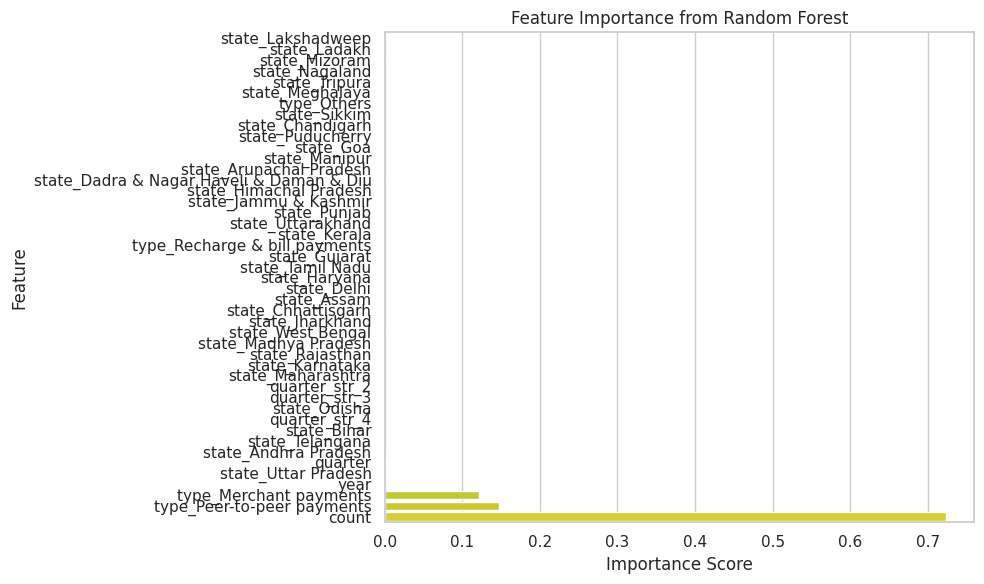

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Business Insight:

This shows which features most influence transaction amount (e.g., count, year, state_Karnataka, etc.)

You can use this to prioritize business focus — e.g., if 'state_Karnataka' and 'quarter_4' are top predictors, then Q4 campaigns in Karnataka are a high priority

#Conclusion


This project delivers a comprehensive, interactive dashboard built on PhonePe Pulse data, offering detailed insights into India's digital payment trends. By visualizing transaction volumes across states, districts, and device brands, the dashboard empowers users to understand regional performance, device preferences, and seasonal variations.

These insights are vital for businesses and analysts aiming to target specific geographies, optimize for popular devices, and plan strategic campaigns based on transaction cycles. Overall, this tool demonstrates the value of data-driven decision-making in the FinTech landscape.